# **Trust by Interrogation**

**Introduction**

In this tutorial, we will go step-by-step throught a model interrogation process that:



1.   Characterises an instances difficulty using a simple instance hardness metric representative of the likelihood an instance will be misclassified
2.   Calculates 4 hardness measures, each representing a source of difficulty from a data perspective
3.   Performs a correlational analysis that identifies which measure most relates to misclassifications within the current task
4.   Identifies which model best handles the source of difficulty associated with misclassifications 

# **Generating Some Data and Predictions**


For the purposes of this tutorial we will generate use Sklearn's 'make_classification' function to create a dataset of 100 instances and 4 features

In [3]:
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

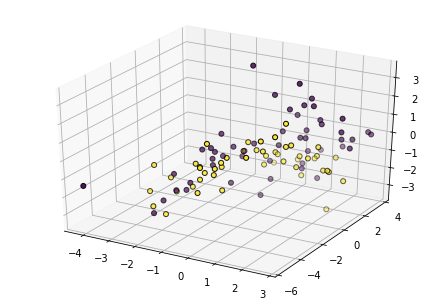

In [4]:
X, y = make_classification(n_features=4, n_redundant=1, n_informative=3,
                             n_clusters_per_class=2)
X = np.array(X)
y = np.array(y)

fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=y,
            s=25, edgecolor='k')

**Generate predictions and probabilites**

We will now generate predictions and classification probabilites using four classifiers (Logistic Regression, SVM, KNN and Random Forest). To generate an output for each instance we will apply leave-one-out cross-validation.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

In [6]:
LR = LogisticRegression()
SVM = SVC(probability=True)
KNN = KNeighborsClassifier()
RF = RandomForestClassifier()
models = [LR,SVM,KNN,RF]

In [7]:
loo = LeaveOneOut()
loo.get_n_splits(X)

truth = []
predictions = []
probabilities = []

for train_index, test_index in loo.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  truth = np.append(truth, y_test)
  
  y_pred = []
  y_prob = []

  for model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_hat_pred = clf.predict(X_test)
    y_hat_prob = clf.predict_proba(X_test)[:,1]

    y_pred = np.append(y_pred, y_hat_pred)
    y_prob = np.append(y_prob, y_hat_prob)
  
  try:
    predictions = np.vstack((predictions, y_pred))
    probabilities = np.vstack((probabilities, y_prob))
  except:
    predictions = y_pred
    probabilities = y_prob

# **Calculating Instance Hardness**

Now that we have a prediction for each instance in the dataset we can calculate a simple instance hardness score, reflecting how likely an instance is to be misclassified by any given classifier. Instance hardness is calculated, as proposed in Smith et al., using: 

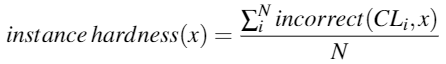

where $x$ refers to a record in the dataset, $N$ refers to the number of classifiers and the function $incorrect(CL_i,x)$ returns 1 if the record $x$ is incorrectly classified by classifier $CL_i$. 

*M. R. Smith and T. Martinez, "Improving classification accuracy by identifying and removing instances that should be misclassified," The 2011 International Joint Conference on Neural Networks, 2011, pp. 2690-2697, doi: https://doi.org/10.1109/IJCNN.2011.6033571*

In [8]:
correct_classifications = np.zeros((X.shape[0],len(models)))

for column in range(len(models)):
  for row in range(X.shape[0]):
    if (truth[row] == predictions[row,column]):
      correct_classifications[row,column] = 1
    else:
      correct_classifications[row,column] = 0
      
instance_hardness = np.mean(correct_classifications,axis=1)

We can visual instance hardness and inspect where in the feature space instances prove to be more difficult.

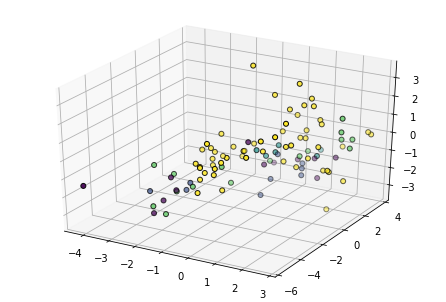

In [9]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=instance_hardness,
            s=25, edgecolor='k')

# **Calculation of Hardness Measures**

All hardness measure presented in this tutorial are taken from Smith et al., 2014.

*Smith, M.R., Martinez, T. & Giraud-Carrier, C. An instance level analysis of data complexity. Mach Learn 95, 225–256 (2014). https://doi.org/10.1007/s10994-013-5422-z*

**Disjunct Size**

Disjunct size measures the complexity of the decision boundary. Firstly, we generate an unpruned decision tree, and identify which disjust or node and instances lies on that tree. We then compare the size of an instance's node to the largest node in the tree, giving us the discjunct size of an instance. The smaller a disjunct, the more challenging an instance is to correctly classify.

Disjunct size is calculated using:

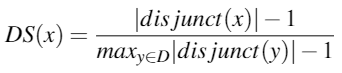

, where the function $disjunct(x)$ returns the disjunct that covers record $x$, $D$ refers to the entire dataset and the functions $disjunct(y)$ returns all disjuncts in the dataset.

In [10]:
from sklearn.tree import _tree

def tree_to_code(tree):
    tree_ = tree.tree_
    feature_name = [i
        for i in tree_.feature
    ]
    print("def return_disjuncts(X):")

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = 'X['+str(feature_name[node])+']'
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, node))

    recurse(0, 1)

The above function prints the rules to the decision tree that is fitted to our data below. **Copy and paste the output in the following cell** and continue running the code.

In [11]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X,y)

tree_to_code(clf)

def return_disjuncts(X):
  if X[3] <= 0.1600869968533516:
    if X[2] <= -0.8219240605831146:
      if X[1] <= 0.528457760810852:
        return 3
      else:  # if X[1] > 0.528457760810852
        if X[3] <= -1.949867069721222:
          if X[1] <= 1.8050979375839233:
            return 6
          else:  # if X[1] > 1.8050979375839233
            if X[2] <= -1.1271065473556519:
              if X[1] <= 1.9476344585418701:
                if X[1] <= 1.8598530292510986:
                  return 10
                else:  # if X[1] > 1.8598530292510986
                  return 11
              else:  # if X[1] > 1.9476344585418701
                return 12
            else:  # if X[2] > -1.1271065473556519
              return 13
        else:  # if X[3] > -1.949867069721222
          return 14
    else:  # if X[2] > -0.8219240605831146
      if X[3] <= -0.47883880138397217:
        if X[2] <= -0.5475900173187256:
          if X[2] <= -0.6489186882972717:
            return 18
          

In [12]:
def return_disjuncts(X):
  if X[3] <= -0.3291766345500946:
    if X[0] <= -0.8270432353019714:
      if X[2] <= 1.8931562304496765:
        if X[2] <= 0.7361383736133575:
          return 4
        else:  # if X[2] > 0.7361383736133575
          if X[0] <= -1.376201868057251:
            return 6
          else:  # if X[0] > -1.376201868057251
            return 7
      else:  # if X[2] > 1.8931562304496765
        return 8
    else:  # if X[0] > -0.8270432353019714
      if X[3] <= -1.3680095076560974:
        return 10
      else:  # if X[3] > -1.3680095076560974
        if X[1] <= -0.8115787208080292:
          return 12
        else:  # if X[1] > -0.8115787208080292
          if X[3] <= -0.9631096422672272:
            return 14
          else:  # if X[3] > -0.9631096422672272
            if X[3] <= -0.6513144671916962:
              return 16
            else:  # if X[3] > -0.6513144671916962
              if X[2] <= -0.1939668245613575:
                return 18
              else:  # if X[2] > -0.1939668245613575
                return 19
  else:  # if X[3] > -0.3291766345500946
    if X[2] <= -3.507072687149048:
      return 21
    else:  # if X[2] > -3.507072687149048
      if X[2] <= 0.9623112082481384:
        return 23
      else:  # if X[2] > 0.9623112082481384
        if X[1] <= -0.5325300507247448:
          return 25
        else:  # if X[1] > -0.5325300507247448
          return 26

In [13]:
Disjuncts = []
for i in range(0, X.shape[0]):
  Disjuncts.append(return_disjuncts(X[i,:]))

unique_disjuncts = set(Disjuncts)
disjunct_sizes = [[x,Disjuncts.count(x)] for x in set(unique_disjuncts)]

disjunct_size = []
for i in range (0,len(disjunct_sizes)):
  disjunct_size.append(disjunct_sizes[i][1])

ds_np = []

for i in range(0, len(Disjuncts)):
  for sizes in range(0,len(unique_disjuncts)):
    if (Disjuncts[i] == disjunct_sizes[sizes][0]):
      if (disjunct_sizes[sizes][1] == max(disjunct_size)):
        ds_np.append(1)
      else:
        ds_np.append((disjunct_sizes[sizes][1]-1)/max(disjunct_size))
DS = np.array(ds_np)

**Disjunct Class Percentage**

Disjunct class percentage represents the overlap of an instance based on a subset of its features. This time a pruned decision tree is fitted to our data and rules generated. We then identify the instances in the same disjunct/node as the current instance and identify what percentage of those instances share the same class as the current instance. The lower the discjunct class percentage the more likely an instance is to be misclassified.

Disjunct class percentage is calculated using:

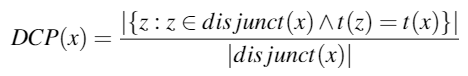

, where $z$ represents the records returned by the functions disjunct(x) belonging to the same class as record $x$.

In [14]:
clf = DecisionTreeClassifier(max_depth = 3)
clf.fit(X,y)

tree_to_code(clf)

def return_disjuncts(X):
  if X[3] <= 0.1600869968533516:
    if X[2] <= -0.8219240605831146:
      if X[1] <= 0.528457760810852:
        return 3
      else:  # if X[1] > 0.528457760810852
        return 4
    else:  # if X[2] > -0.8219240605831146
      if X[3] <= -0.47883880138397217:
        return 6
      else:  # if X[3] > -0.47883880138397217
        return 7
  else:  # if X[3] > 0.1600869968533516
    if X[0] <= -1.9144526720046997:
      if X[0] <= -2.2129340171813965:
        return 10
      else:  # if X[0] > -2.2129340171813965
        return 11
    else:  # if X[0] > -1.9144526720046997
      return 12


Again, the rules of the decision tree will be output above. Like before **copy and paste the output of the above cell into the following cell** and continue running the code.

In [15]:
def return_disjuncts(X):
  if X[3] <= -0.3291766345500946:
    if X[0] <= -0.8270432353019714:
      if X[2] <= 1.8931562304496765:
        return 3
      else:  # if X[2] > 1.8931562304496765
        return 4
    else:  # if X[0] > -0.8270432353019714
      if X[3] <= -1.3680095076560974:
        return 6
      else:  # if X[3] > -1.3680095076560974
        return 7
  else:  # if X[3] > -0.3291766345500946
    if X[2] <= -3.507072687149048:
      return 9
    else:  # if X[2] > -3.507072687149048
      if X[2] <= 0.9623112082481384:
        return 11
      else:  # if X[2] > 0.9623112082481384
        return 12

In [16]:
Disjuncts = []
for i in range(0, X.shape[0]):
  Disjuncts.append(return_disjuncts(X[i,:]))

In [17]:
dcp = []
for i in range(X.shape[0]):
  current_disjunct = np.where(np.array(Disjuncts)==Disjuncts[i])[0]
  current_disjunct = np.delete(current_disjunct, np.where(current_disjunct==i))

  y_disjunct = y[current_disjunct]
  y_curr = y[i]
  y_same = np.where(y_disjunct==y_curr)[0]
  try:
    dcp.append(y_same.shape[0]/y_disjunct.shape[0])
  except:
    dcp.append(1)
DCP = np.array(dcp)

**K-Disagreeing Neighbours**

K-Disagreeing Neighbours reflect the a localised class overlap. K-Disagreeing Neighbours identifies the nearest neighbours to an instances and calculated what percentage of those neighbours are of the same class. We repeat this process for k = 2:17, to mitigate the effect of class size, however, you can change this according to your needs. A greater K-Disagreeing Neighbours score refects a greater possibility of an instance being misclassified.

K-Disagreeing Neighbours is calculated using:

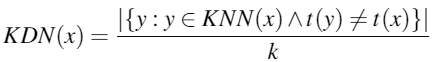

, where the function $KNN(x)$ returns the nearest $k$ neighbours to instance $x$, $t(x)$ returns the class label of record $x$, $y$ represents all instances returned by the functions $KNN(x)$.

In [18]:
from sklearn.neighbors import NearestNeighbors
from numpy import matlib as mb
scores = np.zeros((X.shape[0],15))
for k in range(2,17):
  nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='kd_tree').fit(X)
  _, indices = nbrs.kneighbors(X)
  neighbors = indices[:, 1:]
  diff_class = mb.repmat(y, k, 1).transpose() != y[neighbors]
  scores[:,k-2] = np.sum(diff_class, axis=1) / k
KDN = np.mean(scores,axis=1)

**Class Likelihood Difference**

Class Likelihood Difference represents the global overlap of an instance against the rest of the dataset using all features. Each feature is of an instances is taken and its probablity of being from each of the classes is calculated. The product of all probabilites in each class is the calculated and the difference between an instances probability of belonging to their actual class vs. the maximum probability of it belonging to another class, based on its features is quantified.

Class Likelihood Difference is calculated as follows:

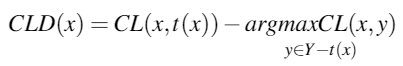

, where the function $CL(x)$ returns the probability of an instance belonging to a certain class, and is derived using equation:

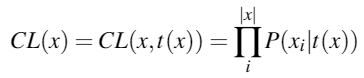

, where $|x|$ is the number of features of instance $x$ and $x_i$ is the value of $x$’s $i$th feature.

In [19]:
from scipy.stats import norm
CLD = []
classes = np.unique(y)
for i in range(0,X.shape[0]):
  probs = np.zeros((X.shape[1],classes.shape[0]))
  for cls in classes:
    thisClass = np.where(y==cls)
    for feature in range(0,X.shape[1]):
      m = np.mean(X[thisClass,feature])
      d = np.std(X[thisClass,feature])
      probs[feature,int(cls)] = norm.pdf(X[i,feature],loc=m,scale=d)
  probsPerClass = np.prod(probs,axis=0)
  classIdx = np.where(classes == y[i])[0]
  ppc_i = probsPerClass[classIdx][0]
  probsPerClass = np.delete(probsPerClass,classIdx)
  ppc_max = np.max(probsPerClass)
  CLD.append(ppc_i-ppc_max)

# **Correlational analysis between Instance Hardness and Hardness Measures**

Now that we have our 4 hardness measure, we can calculate the correlation co-efficient between each of them and instance hardness. This will allow us to identify which measure are the source of difficulty within our classification problem.

In [20]:
import pandas as pd
hardness = np.c_[(instance_hardness*-1)+1,KDN,DCP,CLD,DS]
col_names = ["I_H", "KDN", "DCP", "CLD", "DS"]
hardness_df = pd.DataFrame(data = hardness, columns = col_names)
corr_coef = hardness_df.corr(method='spearman')
corr_coef

,I_H,KDN,DCP,CLD,DS
I_H,1.000000,0.808836,-0.565293,-0.365421,0.089662
KDN,0.808836,1.000000,-0.405604,-0.442065,0.059466
DCP,-0.565293,-0.405604,1.000000,0.318361,0.180907
CLD,-0.365421,-0.442065,0.318361,1.000000,0.279725
DS,0.089662,0.059466,0.180907,0.279725,1.000000


# **Which Classifier Copes Best?**

To understand how each classifier handles the different sources of difficulty we can incrementally add or remove an instance and see how this impacts the performance of each model.

Firstly, we sort our predictions and truth arrays according to each hardness measure.

In [21]:
sorted_predictions_KDN = predictions[np.argsort(-1*KDN),:]
sorted_predictions_CLD = predictions[np.argsort(CLD),:]
sorted_predictions_DS = predictions[np.argsort(DS),:]
sorted_predictions_DCP = predictions[np.argsort(DCP),:]

sorted_truth_KDN = truth[np.argsort(-1*KDN)]
sorted_truth_CLD = truth[np.argsort(CLD)]
sorted_truth_DS = truth[np.argsort(DS)]
sorted_truth_DCP = truth[np.argsort(DCP)]

Now, we calculate an accuracy score, incrementally adding instances. Accuracy score can be replaced by any metric here, however, be mindful that if you wish to use a metric such as AUC, both classes will need to be present in your evaluation set to calculate that measure.

In [22]:
from sklearn.metrics import accuracy_score
def generate_incremental_accuracy_scores(X, models, sorted_truth, sorted_predictions):
  scores = np.zeros(((X.shape[0]*2)-1, len(models)))
  for model in range(0,len(models)): 
    for i in range(0,X.shape[0]):
      scores[i,model] = accuracy_score(sorted_truth[0:i+1],sorted_predictions[0:i+1,model])
      scores[i+X.shape[0]-1,model] = accuracy_score(sorted_truth[i:X.shape[0]],sorted_predictions[i:X.shape[0],model])
  return scores

In [23]:
KDN_scores = generate_incremental_accuracy_scores(X, models, sorted_truth_KDN, sorted_predictions_KDN)
CLD_scores = generate_incremental_accuracy_scores(X, models, sorted_truth_CLD, sorted_predictions_CLD)
DS_scores = generate_incremental_accuracy_scores(X, models, sorted_truth_DS, sorted_predictions_DS)
DCP_scores = generate_incremental_accuracy_scores(X, models, sorted_truth_DCP, sorted_predictions_DCP)

We can see from the plot below, which of our models performs well with respect to the increasing or decreasing influence of each hardness measures. The measure which correlated most strongly with instance hardness should also show the most linear relationship with classification performance in the plot below.

Text(1.2, 0.15, 'Removing patients --> \n with low DCP')

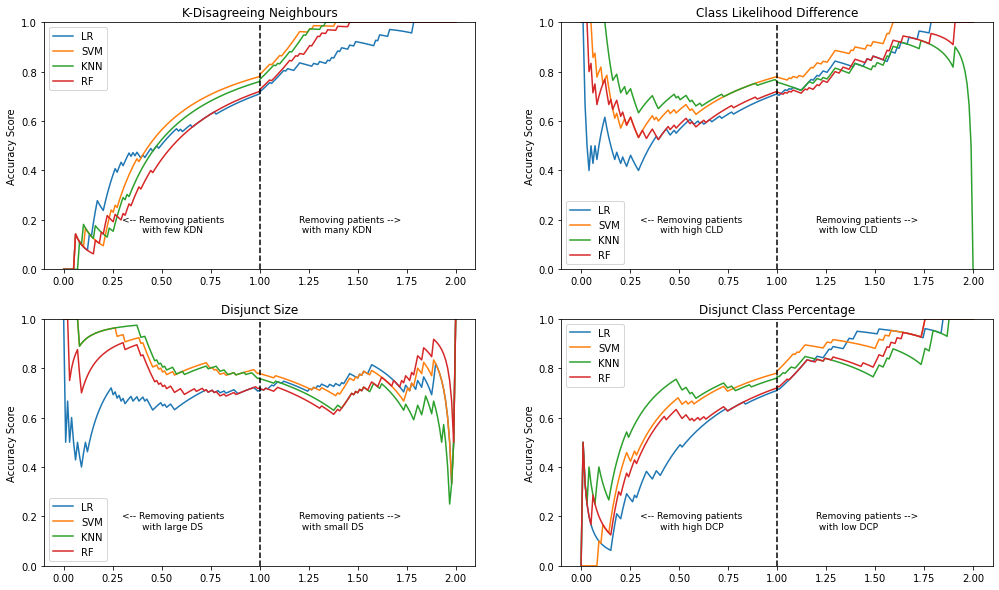

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
x = np.append(np.linspace(0,1,X.shape[0]),np.linspace(1,2,X.shape[0]-1))
fig.set_figheight(10)
fig.set_figwidth(17)

axs[0, 0].plot(x,KDN_scores)
axs[0, 0].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[0, 0].set_title('K-Disagreeing Neighbours')
axs[0, 0].set_ylabel('Accuracy Score')
axs[0, 0].set_ylim([0,1])
axs[0, 0].axvline(x=1,color='k',linestyle='--')
axs[0, 0].text(0.3, 0.15, "<-- Removing patients \n       with few KDN", fontsize=9)
axs[0, 0].text(1.2, 0.15, "Removing patients --> \n with many KDN", fontsize=9)

axs[0, 1].plot(x,CLD_scores)
axs[0, 1].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[0, 1].set_title('Class Likelihood Difference')
axs[0, 1].set_ylabel('Accuracy Score')
axs[0, 1].set_ylim([0,1])
axs[0, 1].axvline(x=1,color='k',linestyle='--')
axs[0, 1].text(0.3, 0.15, "<-- Removing patients \n       with high CLD", fontsize=9)
axs[0, 1].text(1.2, 0.15, "Removing patients --> \n with low CLD", fontsize=9)

axs[1, 0].plot(x,DS_scores)
axs[1, 0].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[1, 0].set_title('Disjunct Size')
axs[1, 0].set_ylabel('Accuracy Score')
axs[1, 0].set_ylim([0,1])
axs[1, 0].axvline(x=1,color='k',linestyle='--')
axs[1, 0].text(0.3, 0.15, "<-- Removing patients \n       with large DS", fontsize=9)
axs[1, 0].text(1.2, 0.15, "Removing patients --> \n with small DS", fontsize=9)

axs[1, 1].plot(x,DCP_scores)
axs[1, 1].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[1, 1].set_title('Disjunct Class Percentage')
axs[1, 1].set_ylabel('Accuracy Score')
axs[1, 1].set_ylim([0,1])
axs[1, 1].axvline(x=1,color='k',linestyle='--')
axs[1, 1].text(0.3, 0.15, "<-- Removing patients \n       with high DCP", fontsize=9)
axs[1, 1].text(1.2, 0.15, "Removing patients --> \n with low DCP", fontsize=9)